In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, roc_curve
import joblib

In [2]:
app_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
bur = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
bur_bal = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
cred_bal = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')
install = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')
pos_bal = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')
prev = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')
apps = pd.concat([app_train, app_test])

In [3]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

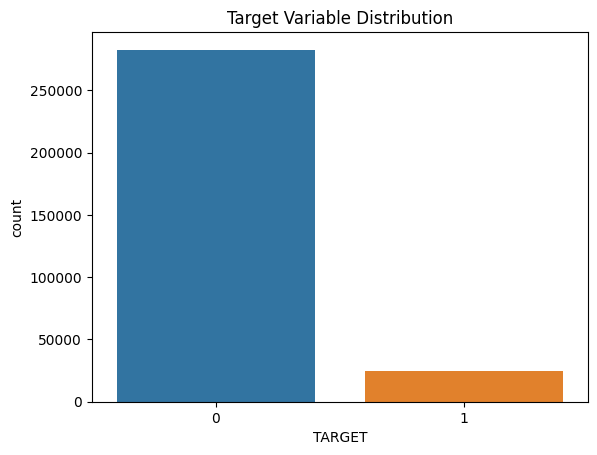

In [5]:
sns.countplot(x='TARGET', data=app_train)
plt.title('Target Variable Distribution')
plt.show()

In [6]:
print("Shape of Bureau dataset is:", bur.shape)
print("Shape of Bureau Balance dataset is:", bur_bal.shape)
print("Shape of Credit card balance dataset is:", cred_bal.shape)
print("Shape of Installments dataset is:", install.shape)
print("Shape of POS cash balance dataset is:", pos_bal.shape)
print("Shape of Previuos applications dataset is:", prev.shape)
print("Shape of Application train dataset is:", app_train.shape)
print("Shape of Application test dataset is:", app_test.shape)
print("Shape of Application dataset is:", apps.shape)

Shape of Bureau dataset is: (1716428, 17)
Shape of Bureau Balance dataset is: (27299925, 3)
Shape of Credit card balance dataset is: (3840312, 23)
Shape of Installments dataset is: (13605401, 8)
Shape of POS cash balance dataset is: (10001358, 8)
Shape of Previuos applications dataset is: (1670214, 37)
Shape of Application train dataset is: (307511, 122)
Shape of Application test dataset is: (48744, 121)
Shape of Application dataset is: (356255, 122)


In [7]:
def missing_values_table(df):
    '''
    This function identifies missing values in a given dataset and presents them in a structured format. It calculates 
    both the absolute number of missing values and their percentage relative to the total entries in each column.

    - Computes the total number of missing values for each column.
    - Calculates the percentage of missing values in relation to the total dataset.
    - Filters out columns with no missing values.
    - Sorts the columns in descending order based on the percentage of missing values.
    - Rounds the percentage values to one decimal place for readability.

    Args:
        df (DataFrame): The input dataset containing various features.

    Returns:
        DataFrame: A table displaying the count and percentage of missing values for each column with missing data.
    '''
    
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\nThere are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [8]:
missing_values = missing_values_table(app_train)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


In [9]:
missing_values = app_train.isnull().mean()
over_50_percent = (missing_values > 0.5).sum()
between_30_50_percent = ((missing_values > 0.3) & (missing_values <= 0.5)).sum()
between_10_30_percent = ((missing_values > 0.1) & (missing_values <= 0.3)).sum()
below_10_percent = (missing_values <= 0.1).sum()

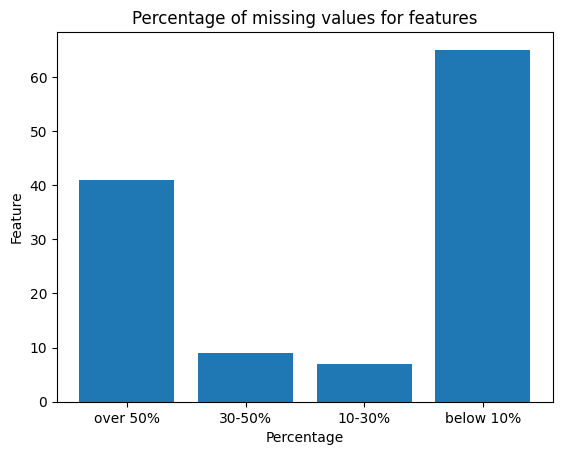

In [10]:
x_labels = ['over 50%', '30-50%', '10-30%', 'below 10%']
y_values = [over_50_percent, between_30_50_percent, between_10_30_percent, below_10_percent]
plt.bar(x_labels, y_values)
plt.title('Percentage of missing values for features')
plt.xlabel('Percentage')
plt.ylabel('Feature')
plt.show()

In [11]:
categorical_cols = app_train.select_dtypes(include=['object']).columns.tolist()

In [12]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


In [13]:
le = LabelEncoder()
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

In [14]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [15]:
correlations = app_train.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [16]:
def apps_agg(apps):
    '''
    This function creates new features by calculating ratios and statistical measures from the given dataset. It mainly focuses on income, credit, employment, and external financial sources to provide meaningful insights.

    - Computes mean and standard deviation of EXT_SOURCE variables.
    - Creates ratios between annuity, credit, goods price, and income.
    - Computes employment and birth-related ratios.
    - Handles missing values by filling NaNs with the mean for standard deviation.

    Args:
        apps DataFrame: The input dataset with financial and demographic features.

    Returns:
        DataFrame: The dataset with added aggregated features.
    '''

    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']

    apps['DAYS_EMPLOYED'] = apps['DAYS_EMPLOYED'].abs()
    apps['DAYS_BIRTH'] = apps['DAYS_BIRTH'].abs()
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    
    if 'OWN_CAR_AGE' in apps.columns:
      apps['OWN_CAR_AGE'] = apps['OWN_CAR_AGE'].abs()
      apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
      apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    # apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    # apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    # apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    # apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    # apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

In [17]:
def prev_processed(prev):
    '''
    This function processes previous credit application data by creating new features and handling missing values.

    - Computes differences between application amount and granted credit/goods price.
    - Creates ratios comparing granted credit and goods price to the applied amount.
    - Replaces invalid date values (365243) with NaN.
    - Computes the difference between two due date variables.
    - Calculates an estimated interest rate based on annuity payments and total credit.

    Args:
        prev DataFrame: The dataset containing previous credit application details.

    Returns:
        DataFrame: The processed dataset with new features and cleaned date values.
    '''
    
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    return prev

In [18]:
def prev_refused_appr_aggn(prev):
    '''
    This function calculates the number of approved and refused loan applications for each customer.

    - Filters previous applications to include only 'Approved' and 'Refused' statuses.
    - Groups by customer ID (`SK_ID_CURR`) and contract status.
    - Counts the number of applications in each category.
    - Converts the grouped data into a table with separate columns for approved and refused counts.
    - Fills missing values with 0 (for customers with no approvals or refusals).

    Args:
        prev DataFrame: The dataset containing previous credit application details.

    Returns:
        DataFrame: A table with customer IDs as index and two columns:
                   'PREV_APPROVED_COUNT' (number of approved applications)
                   'PREV_REFUSED_COUNT' (number of refused applications)
    '''
    
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

    return prev_refused_appr_agg

In [19]:
def bureau_agg(bureau):
    '''
    This function creates new financial ratios and differences based on a customer's credit history from the bureau dataset.

    - Calculates the difference between total credit amount and total debt.
    - Computes the ratio of total debt to total credit.
    - Calculates the difference between the expected end date of credit and the credit start date.
    - Replaces placeholder values (365243) with NaN for missing dates.
    - Computes the difference and ratio between overdue credit and total debt.

    Args:
        bureau DataFrame: The dataset containing credit history details from the bureau.

    Returns:
        DataFrame: The modified dataset with additional computed features.
    '''
    
    # bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    # bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']
    # bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
    
    # bureau['DAYS_CREDIT_ENDDATE'].replace(365243, np.nan, inplace=True)
    # bureau['DAYS_ENDDATE_FACT'].replace(365243, np.nan, inplace=True)
    
    # bureau['BUREAU_CREDIT_OVERDUE_DIFF'] = bureau['AMT_CREDIT_SUM_OVERDUE'] - bureau['AMT_CREDIT_SUM_DEBT']
    # bureau['BUREAU_CREDIT_OVERDUE_RATIO'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / bureau['AMT_CREDIT_SUM']

    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    #bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']
    
    bureau['DAYS_CREDIT_ENDDATE'] = bureau['DAYS_CREDIT_ENDDATE'].abs()
    bureau['DAYS_ENDDATE_FACT'] = bureau['DAYS_ENDDATE_FACT'].abs()
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']

    bureau['DAYS_CREDIT_ENDDATE'].replace(365243, np.nan, inplace=True)
    bureau['DAYS_ENDDATE_FACT'].replace(365243, np.nan, inplace=True)

    #bureau['BUREAU_CREDIT_OVERDUE_DIFF'] = bureau['AMT_CREDIT_SUM_OVERDUE'] - bureau['AMT_CREDIT_SUM_DEBT']
    #bureau['BUREAU_CREDIT_OVERDUE_RATIO'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / bureau['AMT_CREDIT_SUM']

    return bureau

bureau = bureau_agg(bur)

In [20]:
def bureau_balance_agg(bureau_balance):
    '''
    Processes the bureau balance dataset by encoding the STATUS column and computing statistical aggregations for each credit bureau record.

    - Encodes the 'STATUS' column using Label Encoding.
    - Groups data by 'SK_ID_BUREAU' and calculates:
        - Minimum, maximum, mean, and size of 'MONTHS_BALANCE'.
        - Mean of the encoded 'STATUS'.
    - Renames the aggregated columns for clarity.
    - Merges the aggregated results back into the main bureau dataset.

    Args:
        bureau_balance DataFrame: The dataset containing monthly credit status information.

    Returns:
        DataFrame: Aggregated bureau balance statistics per credit bureau record.
    '''
    
    le = LabelEncoder()
    bureau_balance['STATUS'] = le.fit_transform(bureau_balance['STATUS'])

    bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
        'MONTHS_BALANCE': ['min', 'max', 'mean', 'size'],
        'STATUS' : ['mean']
    })
    
    bureau_balance_agg.columns = [f'BUREAU_BALANCE_{col[0]}_{col[1]}' for col in bureau_balance_agg.columns]
    bureau_balance_agg.reset_index(inplace=True)
    
    return bureau_balance_agg

bureau_merged = bureau.merge(bureau_balance_agg(bur_bal), on='SK_ID_BUREAU', how='left')

In [21]:
bureau_merged.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'BUREAU_CREDIT_ENDDATE_DIFF',
       'BUREAU_BALANCE_MONTHS_BALANCE_min',
       'BUREAU_BALANCE_MONTHS_BALANCE_max',
       'BUREAU_BALANCE_MONTHS_BALANCE_mean',
       'BUREAU_BALANCE_MONTHS_BALANCE_size', 'BUREAU_BALANCE_STATUS_mean'],
      dtype='object')

In [22]:
def bureau_agg_by_curr(bureau_merged):
    '''
    Aggregates bureau credit information at the customer level (SK_ID_CURR).

    - Groups data by 'SK_ID_CURR' (each customer).
    - Computes mean and sum for:
        - Difference between total credit amount and debt.
        - Ratio of total debt to credit.
        - Difference between credit end date and credit start date.
        - Difference and ratio of overdue amounts.
    - Extracts min, max, mean, and total count of `MONTHS_BALANCE` from the bureau balance data.
    - Computes the mean of the encoded 'STATUS' from bureau balance data.
    - Flattens multi-level column names for clarity.
    - Resets index for easier merging with the main dataset.

    Args:
        bureau_merged DataFrame: The dataset containing merged bureau and bureau balance data.

    Returns:
        DataFrame: Aggregated credit information per customer (SK_ID_CURR).
    '''

    bureau_agg = bureau_merged.groupby('SK_ID_CURR').agg({
        # 'BUREAU_CREDIT_DEBT_DIFF': ['mean', 'sum'],
        # 'BUREAU_CREDIT_DEBT_RATIO': ['mean', 'sum'],
        'BUREAU_CREDIT_ENDDATE_DIFF': ['mean', 'sum'],
        # 'BUREAU_CREDIT_OVERDUE_DIFF': ['mean', 'sum'],
        # 'BUREAU_CREDIT_OVERDUE_RATIO': ['mean', 'sum'],
        'BUREAU_BALANCE_MONTHS_BALANCE_min': ['min'],
        'BUREAU_BALANCE_MONTHS_BALANCE_max': ['max'],
        'BUREAU_BALANCE_MONTHS_BALANCE_mean': ['mean'],
        'BUREAU_BALANCE_MONTHS_BALANCE_size': ['sum'],
        'BUREAU_BALANCE_STATUS_mean': ['mean']
    })
    
    bureau_agg.columns = [f'BUREAU_{col[0]}_{col[1]}' for col in bureau_agg.columns]
    bureau_agg.reset_index(inplace=True)
    
    return bureau_agg

bureau_final = bureau_agg_by_curr(bureau_merged)

In [23]:
def prev_days365_aggn(prev):
    '''
    Aggregates previous loan application data within the last 365 days at the customer level (SK_ID_CURR) and gives importance to the most recent applications.

    - Filters records where `DAYS_DECISION` is within the past year (`DAYS_DECISION` > -365).
    - Groups data by `SK_ID_CURR` (each customer).
    - Computes mean, max, and sum for various loan-related financial metrics:
        - Credit amount, annuity, application amount, down payment, and goods price.
        - Down payment rate, days since decision, and number of payments.
        - Differences and ratios related to credit and goods amounts.
        - Differences in last due date and interest rates.
    - Flattens multi-level column names for clarity.
    - Returns the processed DataFrame for merging with the main dataset.

    Args:
        prev DataFrame: The dataset containing previous loan application records.

    Returns:
        DataFrame: Aggregated previous application data for customers (SK_ID_CURR).
    '''
    
    cond_days365 = prev['DAYS_DECISION'] > -365
    prev_days365_group = prev[cond_days365].groupby('SK_ID_CURR')
    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_days365_agg = prev_days365_group.agg(agg_dict)

    prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]

    return prev_days365_agg

In [24]:
def prev_amt_aggn(prev):
    '''
    Aggregates previous loan application financial data at the customer level (SK_ID_CURR).

    - Groups data by `SK_ID_CURR` (each customer).
    - Computes mean, max, and sum for key financial metrics:
        - Credit amount, annuity, application amount, down payment, and goods price.
        - Down payment rate, days since decision, and number of payments.
        - Differences and ratios related to credit and goods amounts.
        - Differences in last due date and interest rates.
    - Flattens multi-level column names for clarity.
    - Returns the processed DataFrame for merging with the main dataset.

    Args:
        prev DataFrame: The dataset containing previous loan application records.

    Returns:
        DataFrame: Aggregated previous application financial data for customers (SK_ID_CURR).
    '''

    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
        
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

    return prev_amt_agg

In [25]:
def prev_aggn(prev):
    '''
    Aggregates various features from previous loan applications at the customer level (SK_ID_CURR); (aggregates all the previous fuctions together)

    - Processes the `prev` dataset using `prev_processed()`.
    - Computes financial aggregations using `prev_agg()`.
    - Extracts statistics on refused applications with `prev_refused_appr_agg()`.
    - Aggregates application data within the last 365 days using `prev_days365_agg()`.
    - Merges these aggregated datasets on `SK_ID_CURR` to create a comprehensive view.
    - Computes:
        - `PREV_REFUSED_RATIO`: Ratio of refused applications to total applications.
        - `PREV_APPROVED_RATIO`: Ratio of approved applications to total applications.
    - Drops the intermediate refusal and approval count columns.
    - Returns the processed DataFrame for merging with the main dataset.

    Args:
        prev DataFrame: The dataset containing previous loan application records.

    Returns:
        DataFrame: Aggregated features from previous applications for customers (SK_ID_CURR).
    '''
    
    prev = prev_processed(prev)
    prev_amt_agg = prev_amt_aggn(prev)
    prev_refused_appr_agg = prev_refused_appr_aggn(prev)
    prev_days365_agg = prev_days365_aggn(prev)
    
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

In [26]:
def pos_bal_aggn(pos_bal):
    '''
    Aggregates point-of-sale (POS) and installment payment history at the customer level (SK_ID_CURR).

    - Creates indicators for overdue payments:
        - `POS_IS_DPD`: Whether the customer had any overdue payments.
        - `POS_IS_DPD_UNDER_120`: Overdue payments but less than 120 days.
        - `POS_IS_DPD_OVER_120`: Overdue payments of 120 days or more.
    - Groups by `SK_ID_CURR` and computes:
        - Counts, min, max, mean, and sum for `MONTHS_BALANCE`, `SK_DPD`, `CNT_INSTALMENT`, `CNT_INSTALMENT_FUTURE`, and overdue indicators.
    - Additionally computes the same statistics for records within the last 20 months (`MONTHS_BALANCE` > -20).
    - Flattens multi-level column names for clarity.
    - Merges the overall aggregation with the last 20-months aggregation.
    - Resets index for easier merging with the main dataset.

    Args:
        pos_bal DataFrame: The dataset containing POS and installment payment records.

    Returns:
        DataFrame: Aggregated POS and installment features per customer (SK_ID_CURR).
    '''
    
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x < 120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'max', 'mean'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)
    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)
    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    pos_bal_agg = pos_bal_agg.reset_index()
    
    return pos_bal_agg

In [27]:
def install_aggn(install):
    '''
    Aggregates installment payments data at the customer level (SK_ID_CURR).

    - Creates derived features:
        - `AMT_DIFF`: Difference between the installment amount and the actual payment.
        - `AMT_RATIO`: Ratio of actual payment to installment amount.
        - `SK_DPD`: Days past due (DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT).
    - Creates overdue indicators:
        - `INS_IS_DPD`: Whether the customer was overdue.
        - `INS_IS_DPD_UNDER_120`: Overdue but less than 120 days.
        - `INS_IS_DPD_OVER_120`: Overdue for 120+ days.
    - Aggregates by `SK_ID_CURR`:
        - Count, unique values, mean, min, max, sum for various features.
    - Additionally computes the same statistics for installments within the last year (`DAYS_ENTRY_PAYMENT >= -365`).
    - Merges the overall aggregation with the last 365-day aggregation.
    - Resets index for easier merging with the main dataset.

    Args:
        install DataFrame: The dataset containing installment payment records.

    Returns:
        DataFrame: Aggregated installment features per customer (SK_ID_CURR).
    '''
    
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] + 1) / (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        'AMT_DIFF':['mean','min', 'max','sum'], 
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg

In [28]:
def card_bal_aggn(card_bal):
    '''
    Aggregates card balance data at the customer level (SK_ID_CURR).

    - Creates derived features:
        - `BALANCE_LIMIT_RATIO`: Ratio of balance to credit limit.
        - `DRAWING_LIMIT_RATIO`: Ratio of current drawings to credit limit.
    - Creates overdue indicators:
        - `CARD_IS_DPD`: Whether the customer was overdue.
        - `CARD_IS_DPD_UNDER_120`: Overdue but less than 120 days.
        - `CARD_IS_DPD_OVER_120`: Overdue for 120+ days.
    - Aggregates by `SK_ID_CURR`:
        - Count, mean, max, min, and sum for various features such as AMT_BALANCE, 
          AMT_CREDIT_LIMIT_ACTUAL, AMT_DRAWINGS, etc.
    - Additionally computes the same statistics for card balance records within the last 3 months (`MONTHS_BALANCE >= -3`).
    - Merges the overall aggregation with the last 3-month aggregation.
    - Resets index for easier merging with the main dataset.

    Args:
        card_bal DataFrame: The dataset containing card balance records.

    Returns:
        DataFrame: Aggregated card balance features per customer (SK_ID_CURR)
    '''
    
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],
        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

In [29]:
def apps_all_with_all_agg(apps, prev, pos_bal, install, card_bal):
    '''
    Aggregates and prepares application data by merging various datasets.

    - Aggregates features from multiple datasets:
        - `apps`: Aggregated application data.
        - `prev`: Aggregated previous application data.
        - `pos_bal`: Aggregated point-of-sale balance data.
        - `install`: Aggregated installment data.
        - `card_bal`: Aggregated card balance data.
    - Merges all the aggregated datasets on `SK_ID_CURR` to produce a final result.
    - Joins the data in sequence: `apps_all` -> `prev_agg` -> `pos_bal_agg` -> `install_agg` -> `card_bal_agg`.

    Args:
        apps : The dataset containing application records.
        prev : The dataset containing previous application records.
        pos_bal : The dataset containing point-of-sale balance records.
        install : The dataset containing installment payment records.
        card_bal : The dataset containing card balance records.

    Returns:
        DataFrame: The final merged and aggregated dataset with features from all input datasets.
    '''
    
    apps_all =  apps_agg(apps)
    prev_agg = prev_aggn(prev)
    pos_bal_agg = pos_bal_aggn(pos_bal)
    install_agg = install_aggn(install)
    card_bal_agg = card_bal_aggn(card_bal)

    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(install_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')

    apps_all = apps_all.merge(bureau_final, on='SK_ID_CURR', how='left')

    print('apps_all after merge with all shape:', apps_all.shape)

    return apps_all

In [30]:
def apps_all_with_prev_agg(apps, prev):
    '''
    Aggregates and prepares application data by merging with previous application data.

    - Aggregates features from:
        - `apps`: Aggregated application data.
        - `prev`: Aggregated previous application data.
    - Merges the two datasets on `SK_ID_CURR` to produce the final result.

    Args:
        apps: The dataset containing application records.
        prev: The dataset containing previous application records.

    Returns:
        DataFrame: The final merged and aggregated dataset with features from both `apps` and `prev`.
    '''

    apps_all =  apps_agg(apps)
    prev_agg = prev_aggn(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

In [31]:
def apps_all_encoded(apps_all):
    '''
    Encodes categorical columns in the application data as numeric values.

    - Identifies columns with `object` data type (categorical variables).
    - Applies label encoding (factorization) to convert categorical variables to numeric values.

    Args:
        apps_all DataFrame: The dataset containing application data.

    Returns:
        DataFrame: The dataset with categorical variables encoded as numeric values.
    '''
    
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

In [32]:
def apps_all_train_test(apps_all):
    '''
    Splits the application data into training and test datasets based on the presence of the target variable.

    - The training set (`apps_all_train`) contains rows where the `TARGET` variable is not null.
    - The test set (`apps_all_test`) contains rows where the `TARGET` variable is null.
    - The `TARGET` column is dropped from the test set.

    Args:
        apps_all DataFrame: The dataset containing application data, including the `TARGET` column.

    Returns:
        tuple: A tuple containing two DataFrames:
            - `apps_all_train`: The training dataset with the `TARGET` column.
            - `apps_all_test`: The test dataset without the `TARGET` column.
    '''
    
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test

In [36]:
def get_selected_feature_values(apps_all_train, categorical_cols, numerical_cols, selected_features): #NEW FUNCTION
    """
    Creates a dictionary of feature values for selected features in the apps_all_train dataset.

    Args:
        apps_all_train (pd.DataFrame): The training dataset after aggregation.
        categorical_cols (list): List of categorical column names.
        numerical_cols (list): List of numerical column names.
        selected_features (list): List of selected feature names (from SelectFromModel)
    """
    feature_values = {}
    for col in categorical_cols:
        if col in selected_features:
            feature_values[col] = list(apps_all_train[col].unique())

    for col in numerical_cols:
        if col not in categorical_cols:
            if col in selected_features:
                feature_values[col] = {'min': apps_all_train[col].min(), 'max': apps_all_train[col].max()}

    return feature_values

In [39]:
def train_apps_all(apps_all_train):
    '''
    Trains a LightGBM classifier on the application data for predicting the target variable, 
    incorporating feature selection based on the top 50 feature importances.

    - Drops the `SK_ID_CURR` and `TARGET` columns from the dataset for feature selection.
    - Splits the data into training and validation sets (80-20 split).
    - Trains a LightGBM classifier (`LGBMClassifier`) to get feature importances.
    - Selects the top 50 most important features for final model training.
    - Trains a final LGBMClassifier on the selected features with specified hyperparameters.
    - The model is evaluated using AUC metric and early stopping is applied to prevent overfitting.

    Args:
        apps_all_train (DataFrame): The dataset containing application data with the target variable `TARGET`.

    Returns:
        tuple: A tuple containing:
            - `clf`: The trained LightGBM classifier (on selected features).
            - `train_x_selected`: The training features (selected features only).
            - `train_y`: The training target labels.
            - `valid_x_selected`: The validation features (selected features only).
            - `valid_y`: The validation target labels.
            - `top_50_features`: The list of selected feature names.
    '''
    
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    tarapp = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, tarapp, test_size=0.2, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)

    lgb_for_selection = LGBMClassifier(
        objective='binary',
        metric='auc',
        n_estimators=1000, 
        n_jobs=-1,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.7,
        num_leaves=31,
        max_depth=-1,
        random_state=42,
        is_unbalance=True,
        silent=-1,
        verbose=-1
    )

    lgb_for_selection.fit(train_x, train_y)

    feature_importances = pd.DataFrame({
        'feature': train_x.columns,
        'importance': lgb_for_selection.feature_importances_
    })
    
    top_50_features = feature_importances.sort_values(by='importance', ascending=False).head(50)['feature'].tolist()
    train_x_selected = train_x[top_50_features]
    valid_x_selected = valid_x[top_50_features]

    print("Shape of training data after feature selection:", train_x_selected.shape)
    print("Shape of validation data after feature selection:", valid_x_selected.shape)

    clf = LGBMClassifier(
                max_depth=10,
                n_estimators=1500,
                learning_rate=0.02,
                min_child_weight=6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                class_weight={0:1, 1:2}
                )
   
    clf.fit(train_x_selected, train_y, 
            eval_set=[(train_x_selected, train_y), (valid_x_selected, valid_y)], 
            eval_metric='auc', 
            verbose=100, 
            early_stopping_rounds=200)
    
    return clf, train_x_selected, train_y, valid_x_selected, valid_y, top_50_features

In [40]:
apps_all = apps_all_with_all_agg(apps, prev, pos_bal, install, cred_bal)  #complete aggregation
del apps,prev,pos_bal,install,cred_bal
gc.collect()

numerical_cols = apps_all.select_dtypes(include=['int64', 'float64']).columns.tolist()

apps_all after merge with all shape: (356255, 386)


In [53]:
feature_values = get_selected_feature_values(apps_all_train, categorical_cols, numerical_cols, top_50_features)

apps_all = apps_all_encoded(apps_all)
apps_all_train, apps_all_test = apps_all_train_test(apps_all)
clf, train_x_selected, train_y, valid_x_selected, valid_y, top_50_features = train_apps_all(apps_all_train)

joblib.dump(clf, 'lgbm_model.joblib')
joblib.dump(top_50_features, 'selected_features.joblib')
joblib.dump(categorical_cols, 'categorical_features.joblib')
joblib.dump(numerical_cols, 'numerical_features.joblib')
joblib.dump(feature_values, 'feature_values.joblib')

apps_all_test = apps_all[apps_all['TARGET'].isnull()].drop(['TARGET', 'SK_ID_CURR'], axis=1)
apps_all_test_selected = apps_all_test[top_50_features]

preds = clf.predict_proba(apps_all_test_selected)[:, 1]
print("Saved model, selected features, and categorical features to joblib files.")

train shape: (246008, 384) valid shape: (61503, 384)


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Shape of training data after feature selection: (246008, 50)
Shape of validation data after feature selection: (61503, 50)


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[100]	training's auc: 0.767591	training's binary_logloss: 0.365045	valid_1's auc: 0.75721	valid_1's binary_logloss: 0.26672
[200]	training's auc: 0.786652	training's binary_logloss: 0.3525	valid_1's auc: 0.769661	valid_1's binary_logloss: 0.261099
[300]	training's auc: 0.798545	training's binary_logloss: 0.345354	valid_1's auc: 0.773956	valid_1's binary_logloss: 0.259023
[400]	training's auc: 0.807767	training's binary_logloss: 0.340128	valid_1's auc: 0.776191	valid_1's binary_logloss: 0.257958
[500]	training's auc: 0.815389	training's binary_logloss: 0.335906	valid_1's auc: 0.776853	valid_1's binary_logloss: 0.257497
[600]	training's auc: 0.822567	training's binary_logloss: 0.331963	valid_1's auc: 0.777248	valid_1's binary_logloss: 0.257119
[700]	training's auc: 0.829314	training's binary_logloss: 0.328245	valid_1's auc: 0.77746	valid_1's binary_logloss: 0.256799
[800]	training's auc: 0.835775	training's binary_logloss: 0.324685	valid_1's auc: 0.777728	valid_1's binary_logloss: 0.2564

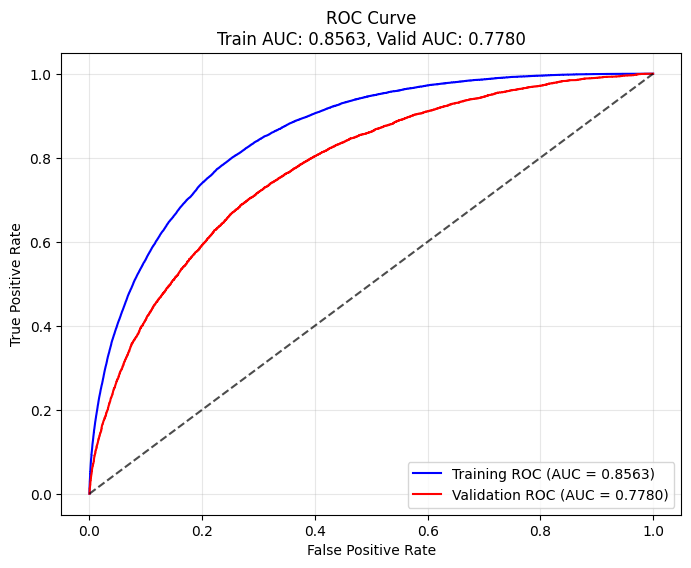

In [52]:
y_train_pred = clf.predict_proba(train_x_selected)[:, 1]
y_valid_pred = clf.predict_proba(valid_x_selected)[:, 1]  # Predictions for validation set

auc_train = roc_auc_score(train_y, y_train_pred)
auc_valid = roc_auc_score(valid_y, y_valid_pred)

fpr_train, tpr_train, _ = roc_curve(train_y, y_train_pred)
fpr_valid, tpr_valid, _ = roc_curve(valid_y, y_valid_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {auc_train:.4f})', linestyle='-', color='blue')
plt.plot(fpr_valid, tpr_valid, label=f'Validation ROC (AUC = {auc_valid:.4f})', linestyle='-', color='red')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.7)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve\nTrain AUC: {auc_train:.4f}, Valid AUC: {auc_valid:.4f}')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

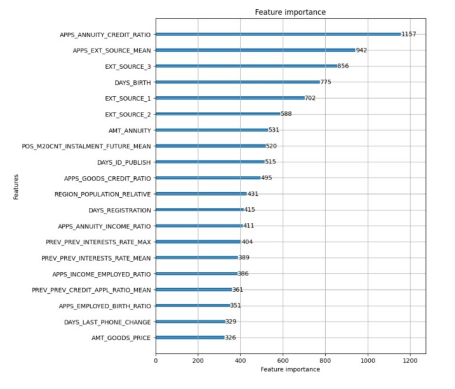

In [2]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(8, 10), max_num_features=20)